# Análisis del modelo [beto-sentiment-analysis](https://huggingface.co/finiteautomata/beto-sentiment-analysis)

Este análisis se llevó a cabo utilizando la herramienta [Languaje Interpretability Tool](https://pair-code.github.io/lit/)

Los modelos preentrenados se utilizan cada vez más hoy en día. El costo de desarrollar modelos propios es muy alto para gran cantidad de empresas: no solo en cuanto a poder de cómputo sino tambien en cantidad de datos necesarios, tiempo de desarrollo y necesidad de personal más calificado que se dedique particularmente a la tarea de desarrollar modelos propios.

Durante el desarrollo de los modelos se genera mucho conocimiento sobre el comportamiento del modelo que quienes los utilizan desconocen, y es poco común encontrar documentación detallada y métricas que permitan entender más a fondo el impacto de utilizar estos modelos en distintos entornos/casos de uso.

Por ejemplo, si yo quisiera insertar un modelo preentrenado con datos de twitter argentina en twitter méxico, donde algunas características del lenguaje son distintas, es importante que pueda realizar pruebas que me permitan entender a fondo el comportamiento del modelo con estos datos nuevos.

Existen herramientas como LIT que permiten entender con mayor profundidad el comportamiento del modelo, tanto en sus datos de entrenamiento como en datos nuevos.

Analisis black-box del modelo beto-sentiment-analysis
En la primer parte del análisis vamos a enfocarnos en analizar métricas más tradicionales que no necesitan de una implementación sofisticada de alguna técnica neuronal o con transformers. A medida que avance el análisis va a requerir de más sofisticación técnica y de implementación

En la primer parte del análisis  vamos a enfocarnos en analizar métricas más tradicionales que no necesitan
de una implementación sofisticada de alguna técnica neuronal o con transformers.
A medida que avance el análisis va a requerir de más sofisticación técnica y de implementación

# Matriz de confusión
En la esquina inferior derecha, en la pestaña Metrics, podemos acceder a la matriz de confusión de nuestro modelo

La matriz se interpreta de la siguiente manera:
Cada uno de los valores representa el porcentaje de error/acierto en cada clase particular, donde
la fila corresponde a la etiqueta del dato y la columna a la etiqueta predicha por el modelo:

### Train:
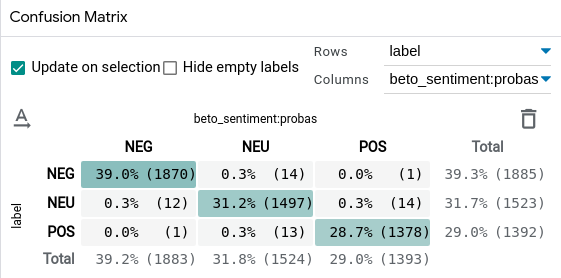

### Dev:

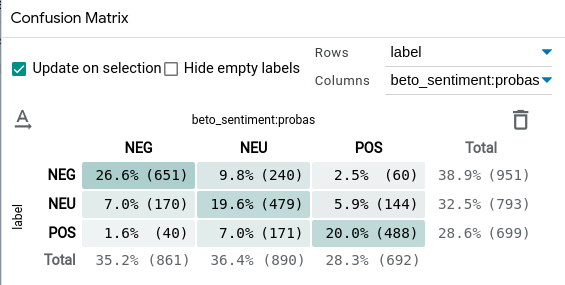

Esto nos permite saber, por ejemplo, que el modelo confunde positivos con neutrales, neutrales con negativos y con positivos.
A su vez, al menos dentro de los datos de entrenamiento, no confunde positivos con negativos. Esta es una característica deseable,
y es positivo ver que se mantiene en los datos de test. 

Algo que nos va a interesar observar son las predicciones de los datos de test en donde el modelo confunde POS con NEG. Estas deberían
ser clases "opuestas", ya que los casos dudosos suelen considerarse neutrales.
Acá podemos encontrar puntos débiles del modelo y datos mal etiquetados.

## Dev: Análisis estratificando por pais
Un análisis muy interesante y necesario que nos permite hacer LIT, es estratificar estas métricas segun alguna feature en particular de los datos.
Esto resulta útil solamente en los casos que tenemos alguna clase de información adicional, pero es muy importante detectar las brechas en el rendimiento del modelo y si alguna clase está sufriendo de errores sistemáticos.


Para esto debemos crear una "slice" de nuestros datos por cada valor de la columna country.
Nos vamos a la pestaña "slice editor" que se encuentra minimizada en el bloque del medio a la derecha
y marcamos country en "Slice by feature", un nombre que será el prefijo de la slice,
y "create slice"

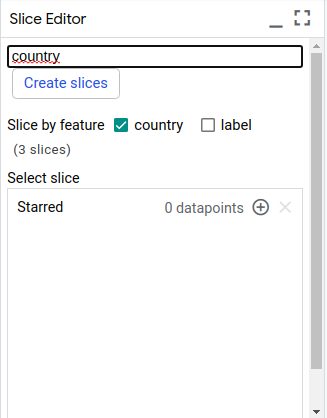

Ahora tenemos una slice de los datos por cada uno de los paises presentes en los mismos.

Ahora al seleccionar una slice vamos a poder acceder a la matriz de confusión de esa 
parte de los datos.

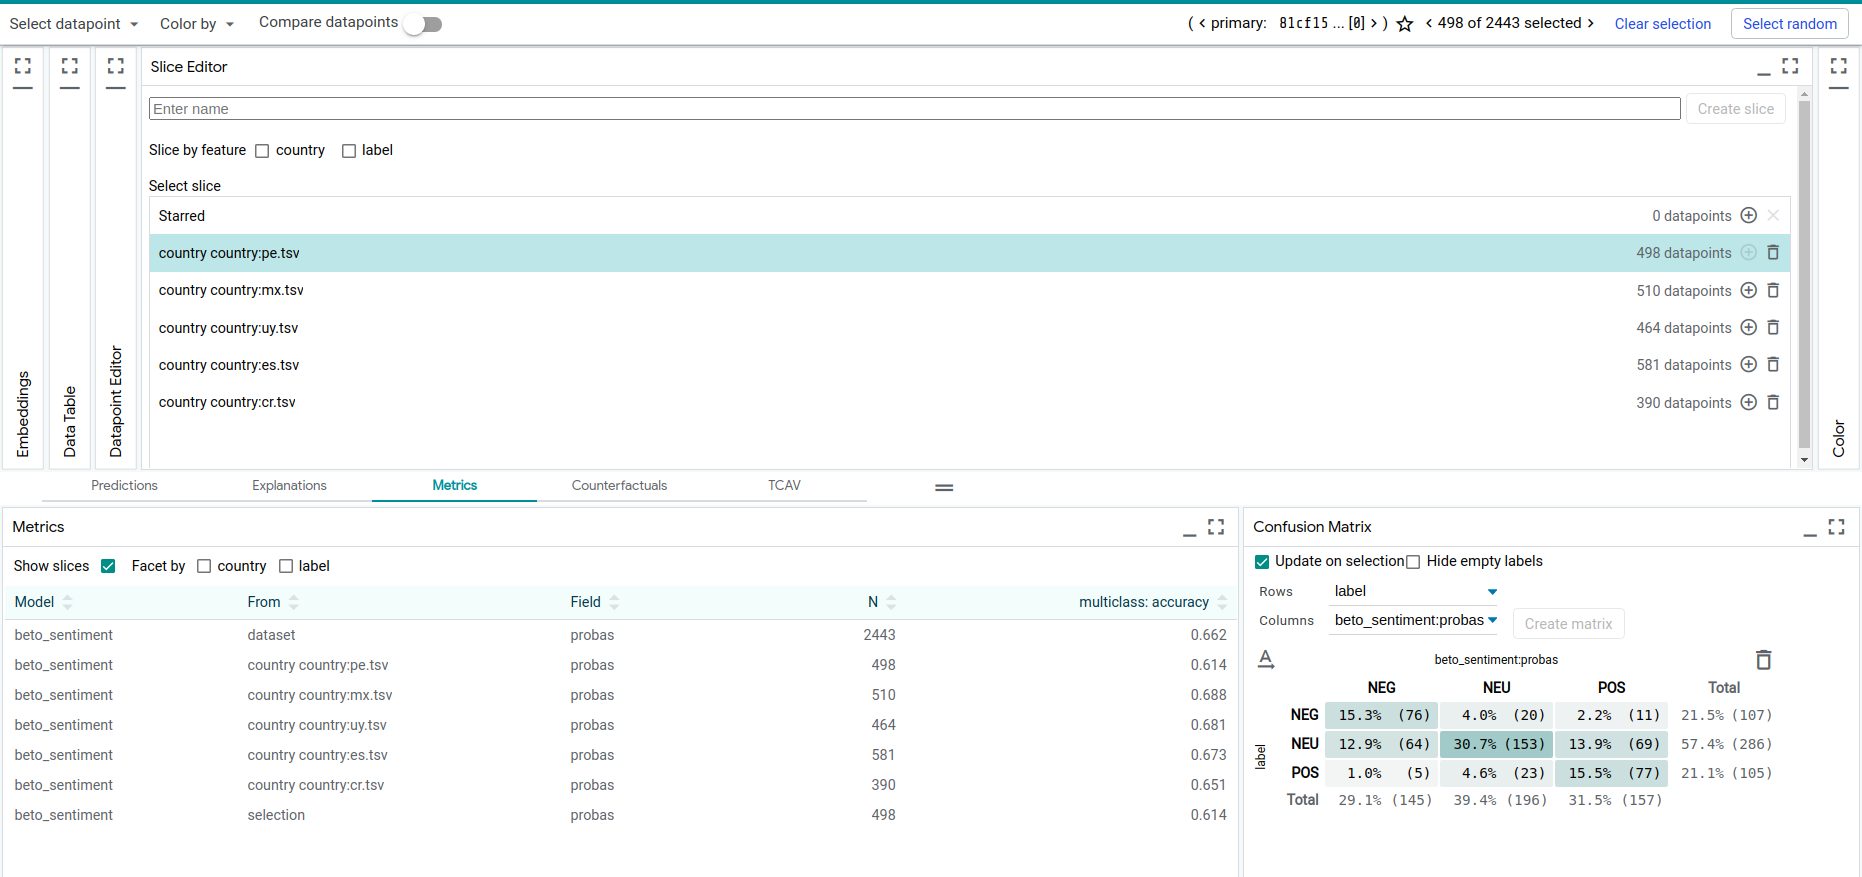

### Perú 
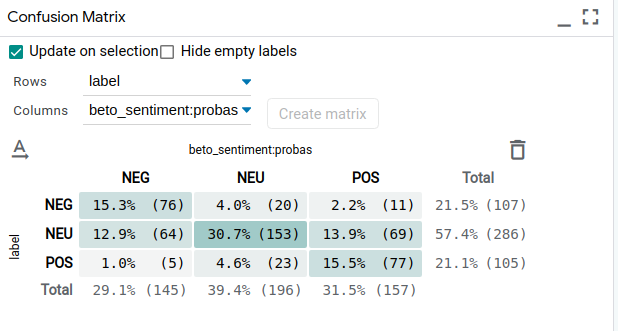

### México

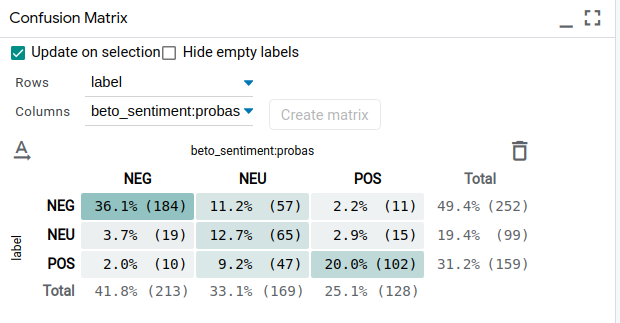

### Uruguay

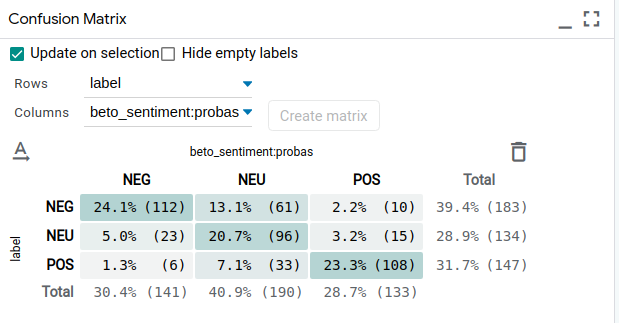

### España

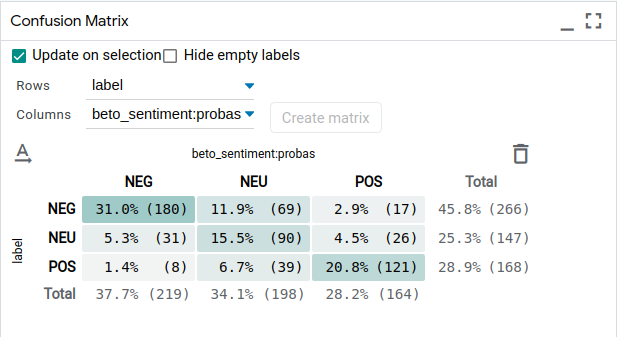

### Costa Rica

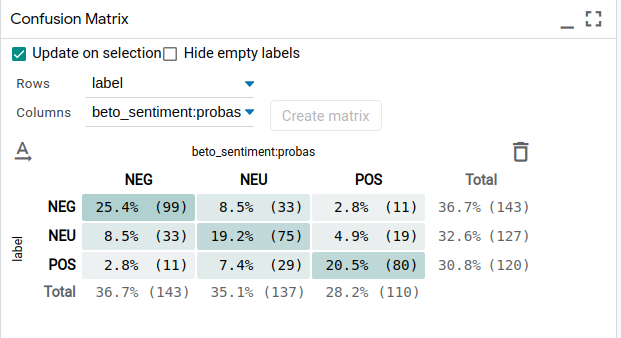

Si bien no existen diferencias terribles en el desempeño del modelo, podemos ver que se comporta distinto en las distintas variantes de Español:

Errores concentrados en la **fila central**:
Esto sucede cuando el modelo califica como positivo o negativos tweets neutrales. 
Esto puede pasar porque hay tweets que son positivos y negativos a la vez, porque podrían
estar expresando un poco de cada emoción. En este caso, se podría implementar una solucion
ad-hoc que modifique la predicción del modelo para hacerla neutral en estos casos.
Vamos a poder comprobar esta hipótesis con otras herramientas que veremos luego.


Esto podría indicar que el modelo en estas variantes particulares es más sensible
a algunas palabras que hacen que las predicciones se vayan para alguno de los dos lados.


Errores concentrados en la **columna central**:
Esto sucede cuando el modelo clasifica como neutrales tweets positivos o negativos.
Esto podría deberse a que el modelo no entiende como negativas/positivas ciertas palabras que sí lo son.
En este caso, podría estar sucediendo que las predicciones que tienen proporcion similar de neutral-positivo
o neutral-negativo, queden clasificadas como neutrales por una pequeña diferencia.
Al igual que en el error anterior, podríamos decidir clasificar estas predicciones como positivas o negativas.


Luego vamos a intentar entender los posibles motivos de estos comportamientos, analizando cada grupo de datos particular.

# Scalars

En la pestaña predictions podemos realizar un análisis sobre la distribución de probabilidad de cada punto para cada clase particular.
Clickeando en cualquiera de los puntos, obtenemos información sobre la etiqueta real, el texto, y las probabilidades que el modelo predijo para cada clase.

En la esquina superior izquierda, en la opción "Color by" podemos seleccionar distintas formas de colorear los datapoints. 
Para este análisis vamos a colorear por beto_sentiment:probas is_correct. Las predicciones correctas se colorean en azul y las incorrectas en rojo. 


# Clase real: NEU Clase predicha: NEG
Tomemos la slice de datos de perú, donde el modelo predice positivos o negativos tweets neutrales.
Hay 2 casos posibles: 
- Predijo con mucha probabilidad que sea NEG: esto indica sensibilidad del modelo a ciertas palabras/atributos, y es una buena partición para buscar etiquetas incorrectas.
- Predijo con probabilidad similar neutral y negativo: estos casos son bastante entendibles, y dependiendo de nuestros datos y caso de uso podríamos querer diseñar reglas para manejar mejor estos casos.

Podemos obtener scalars de ciertos grupos particulares de errores seleccionandolos en la matriz de confusión:
En el siguiente gráfico tenemos seleccionada la slide de Perú, la fila NEU columna NEG de la matriz de confusión, y lo que nos va a interesar mirar
son los puntos con borde blanco.

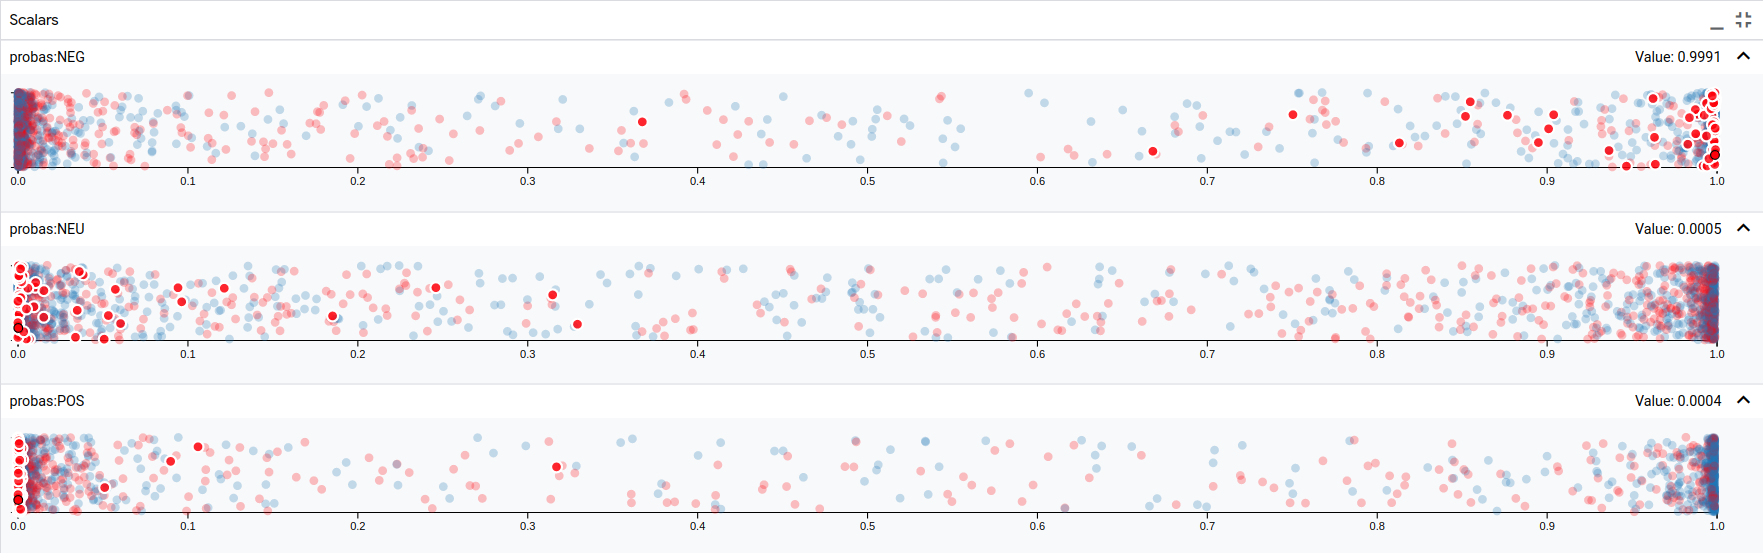

En la gran mayoría de los casos el modelo asigno con mucha confianza las predicciones a la clase negativa, solo en unas poquitas predicciones tenía proporciones parecidas de neutralidad o negatividad.


Si vamos a la pestaña Data Table, y en columns seleccionamos 
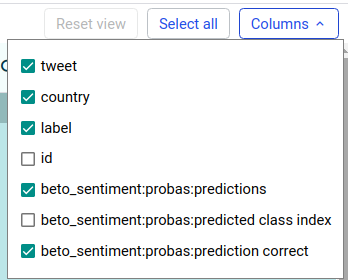

y maximizamos la pestaña, podemos inspeccionar fácilmente varias de las predicciones así como la probabilidad asignada por el modelo.

El indice 0 corresponde a clase negativa, el 1 a neutral y el 2 a positivo.
En esta tabla podemos identificar varios tweets clasificados incorrectamente, así como encontrar conceptos que podrían estar muy fuertemente
asociados a sentiment negativo y querríamos evitar:


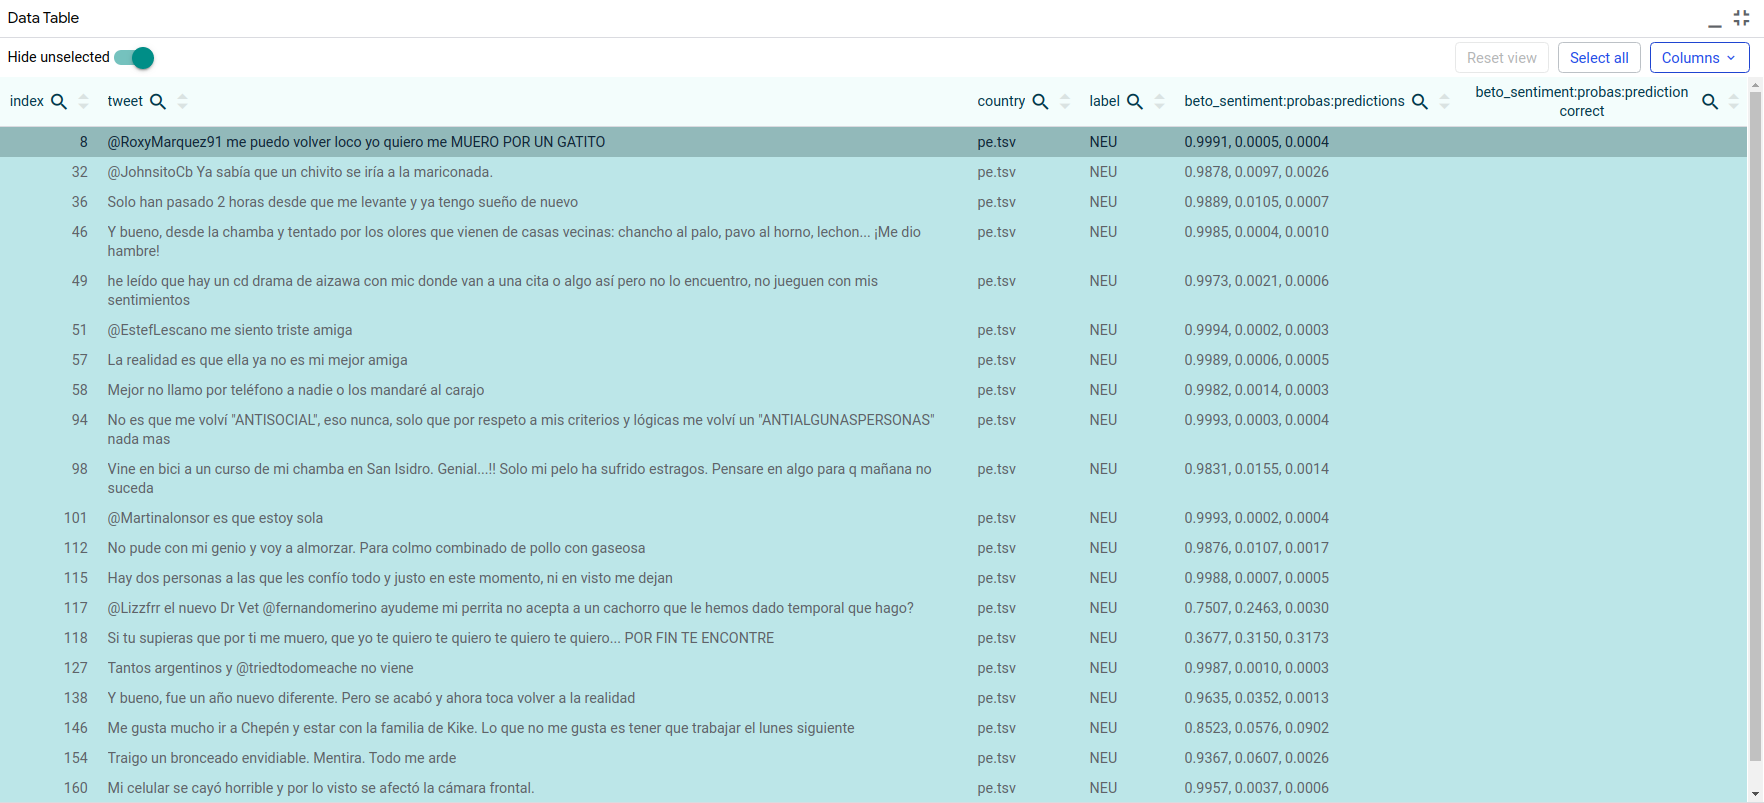


En esta tabla podemos encontrar algunos ejemplos mal etiquetados, es decir, que no están asociados a emociones neutrales si no más bien negativas
LIT no provee aun funcionalidad para poder corregir estos errores y poder guardarnos datos "más limpios".

Nos vamos a concentrar en las que sí tienen la etiqueta correcta y podrían estar reflejando sesgos en el modelo.

# Going down the rabbit-hole

Tomemos un ejemplo particular:

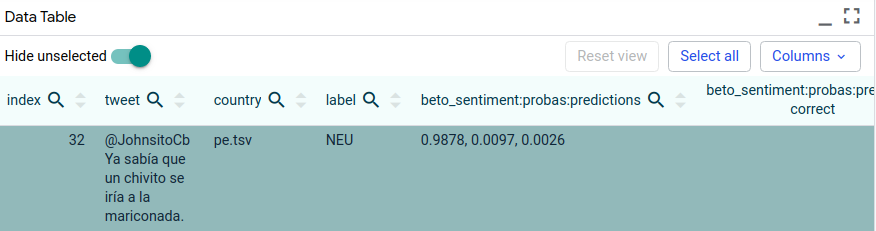

Hipotesis: mariconada/marica/maricon es un concepto fuertemente asociado a significados negativos:

Cómo podemos probar esta hipótesis con la ayuda de LIT? Esto depende del grado de sofisticación de nuestro modelo.

### LIME
Para continuar con el análisis a modo black-box, vamos a utilizar LIME para observar mapas de saliencia ya que esta técnica
genera las explicaciones sin acceder a ninguna clase de comportamiento interno del modelo :)
En pocas palabras, funciona generando un conjunto de inputs perturbados, ya sea quitando o enmascarando tokens y entrena un modelo lineal
para reconstruir la predicción. Los pesos en este modelo lineal son los que se utilizan como valores de saliencia.

Es importante saber como funciona ya que muchas veces eliminar tokens cambia completamente el sentido de la oración y podría cambiar
mucho las predicciones.

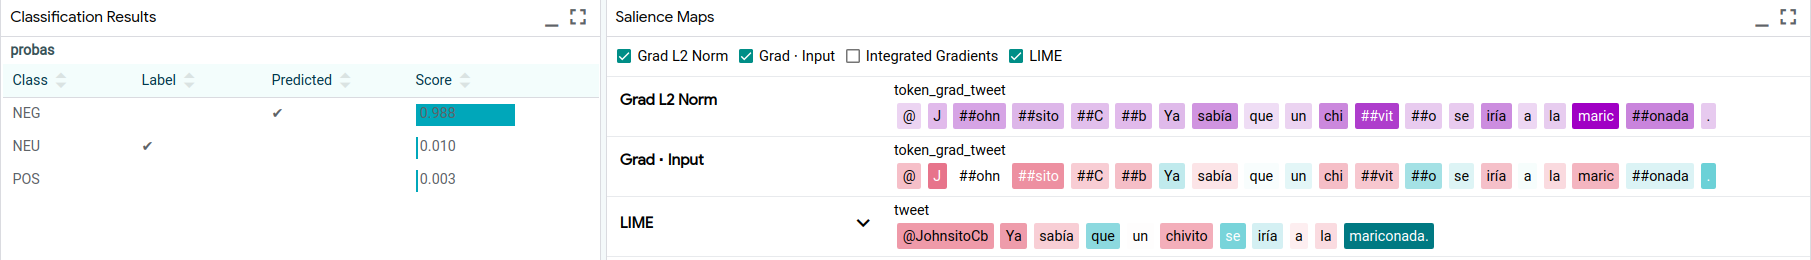


# Buscar otros casos

Otra cosa que podemos hacer para verificar esta hipotesis es buscar tweets que contengan la palabra que nos interesa analizar y ver cómo funciona el modelo en estos casos.
Sin embargo, no hay muchos ejemplos de estos datos

Algo que podemos acceder en este caso, es a los datos de entrenamiento: 

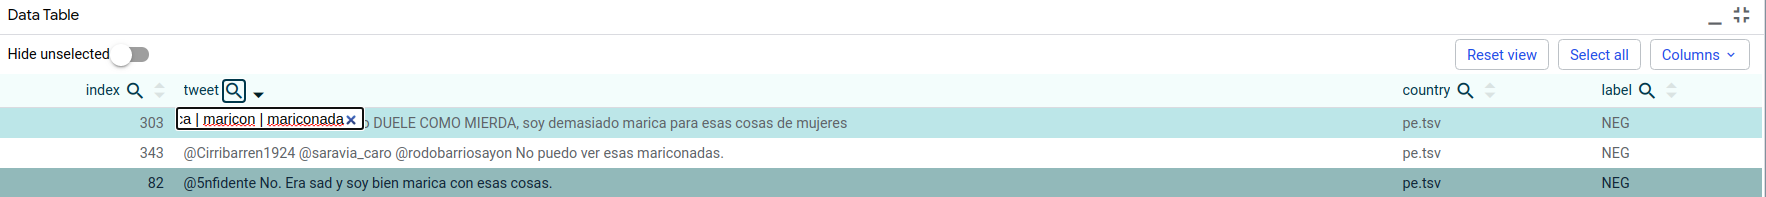

Encontramos que las unicas 3 ocurrencias de tweets con la palabra "maricon | marica | mariconada" están asociados con sentimientos negativos.


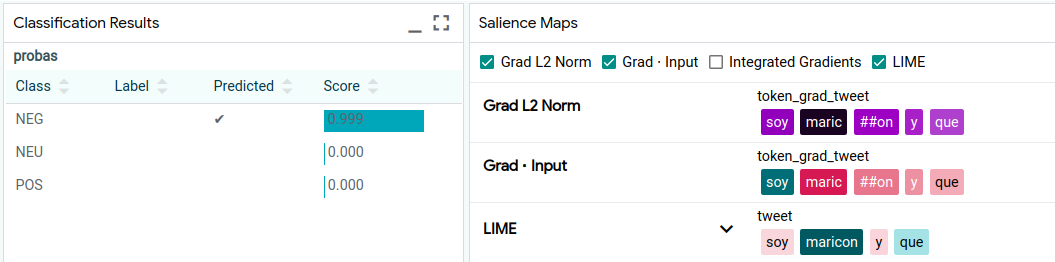



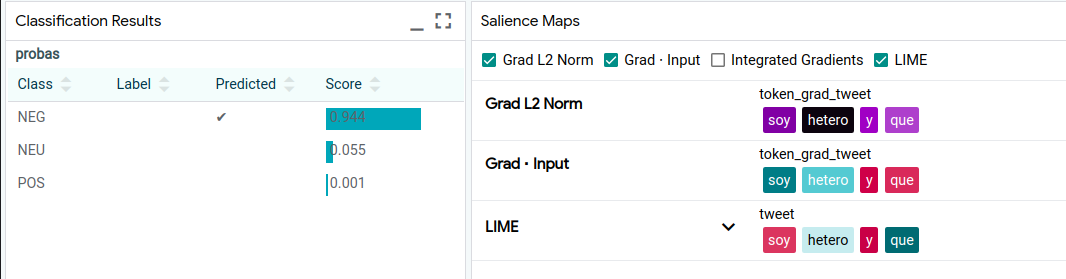

¿Cómo podemos modificar este comportamiento sin tener que reentrenar este modelos?
No podemos :D solo podemos saber que esto ocurre, ser conscientes de ello y trabajar para mejorar nuestras formas de evaluación.


# Generar datos artificiales

Es probable que no tengamos muchos datos donde aparezca esta palabra, pero LIT nos permite cargar datos artificiales de manera muy sencilla.
De esta manera podemos probar nuestro modelo y averiguar su comportamiento

# Búsqueda de etiquetas incorrectas:


## Utilizando scalars
Utilizando los gráficos de scalars podemos detectar datos que podrían estar mal etiquetados. 

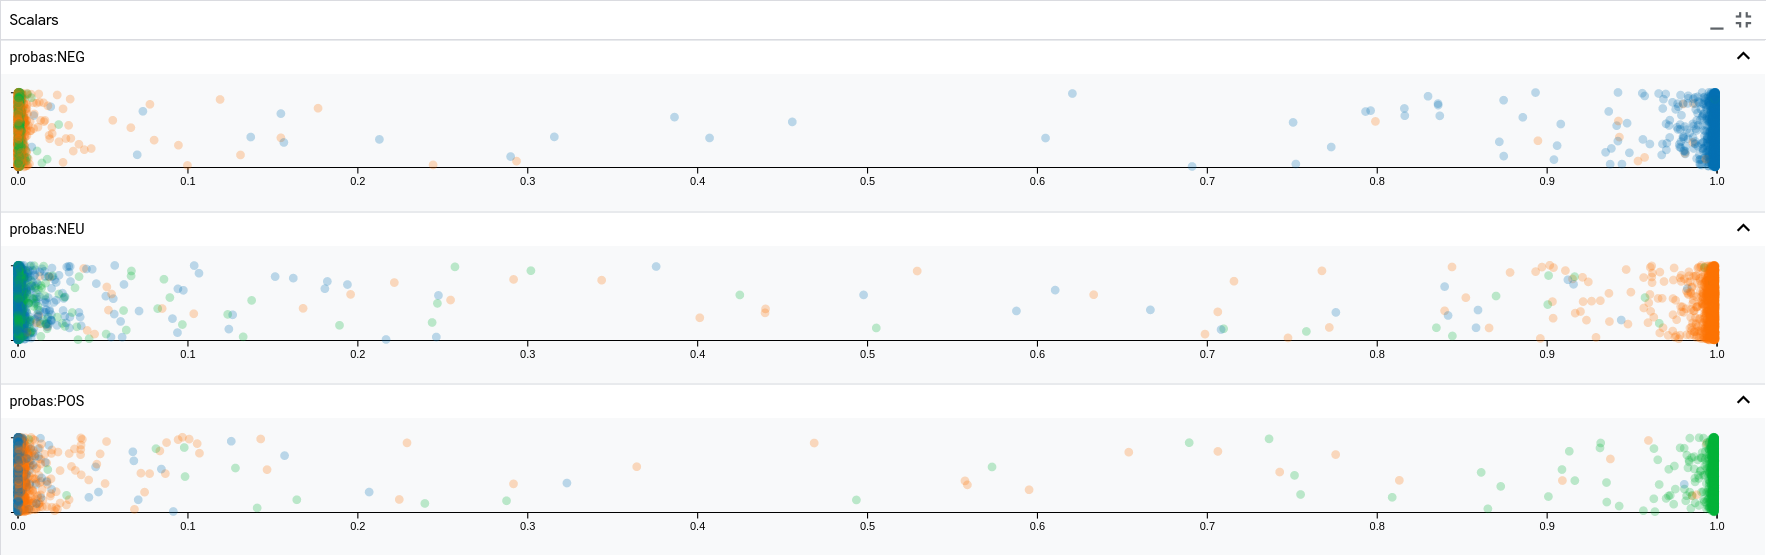


Vamos a utilizar Color by: label y lo que nos va a interesar observar son los extremos derechos del gráfico, donde veamos
puntos de un color distinto a la mayoría. 

Lo que podemos observar en este caso es algo que ya vimos con la matriz de confusión: 
- En la clase NEG, el modelo 



## Utilizando la proyección a un espacio de embeddings

# Features que agregaría:

- Seleccionar predicciones, cambiar las etiquetas y poder editar el dataset y guardarlo editado
- Zoom en los distintos plots, o poder seleccionar una región de puntos desde los distintos gráficos